In [33]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as function
import torch.optim as optim
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from numpy import mean
from numpy import std
from matplotlib import pyplot

Load the data from UCI website. It's a matlab file.

In [34]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/character-trajectories/mixoutALL_shifted.mat
mat_data = scipy.io.loadmat('mixoutALL_shifted.mat')
constants = mat_data['consts'][0][0]
constants_charlabels = constants[4][0] - 1
mixout = mat_data['mixout'][0]

--2020-11-01 00:27:07--  https://archive.ics.uci.edu/ml/machine-learning-databases/character-trajectories/mixoutALL_shifted.mat
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7912437 (7.5M) [application/x-httpd-php]
Saving to: ‘mixoutALL_shifted.mat.5’

mixoutALL_shifted.m 100%[===================>]   7.54M  6.38MB/s    in 1.2s    

2020-11-01 00:27:09 (6.38 MB/s) - ‘mixoutALL_shifted.mat.5’ saved [7912437/7912437]



Helper functions to draw characters.

In [35]:
def draw_character(character_vector):
    x_val  = character_vector[0]
    y_val  = character_vector[1]
    z_val  = character_vector[2]
    x_pos  = np.cumsum(x_val)
    y_pos  = np.cumsum(y_val)
    z_pos  = np.cumsum(z_val)
    x_pos  = np.insert(x_pos[:-1],0,0)
    y_pos  = np.insert(y_pos[:-1],0,0)
    z_pos  = np.insert(z_pos[:-1],0,0)
    val = z_pos + 1/2*0.04*(x_pos*y_pos)
    colormap = cm.Blues
    plt.quiver( x_pos,y_pos, x_val,y_val, color=colormap(val) )
    plt.show()

def plot_character():
  for index,key in enumerate(constants[3][0]):
    print('Character ->', key)
    keys_indexes = np.where(constants_charlabels==index)[0]
    plot_index = np.random.choice(keys_indexes)
    draw_character(mixout[plot_index])

Plot the data

Character -> ['a']


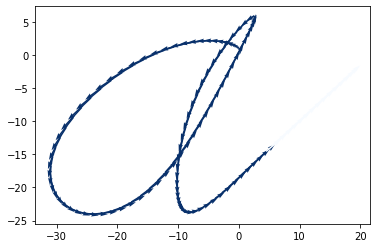

Character -> ['b']


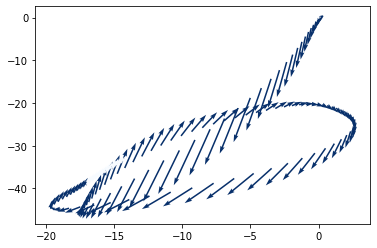

Character -> ['c']


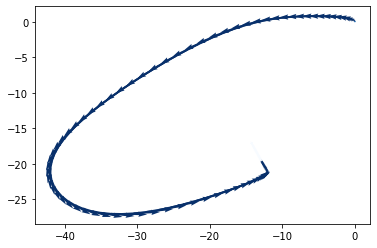

Character -> ['d']


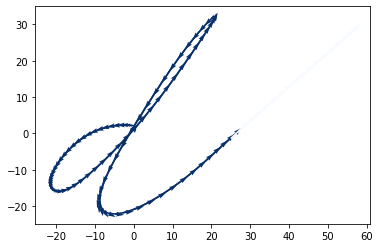

Character -> ['e']


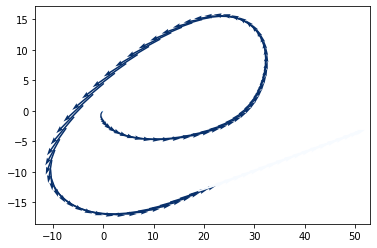

Character -> ['g']


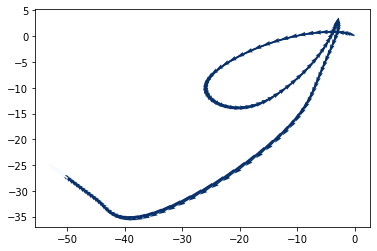

Character -> ['h']


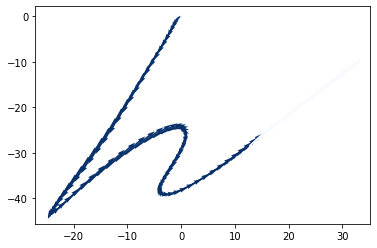

Character -> ['l']


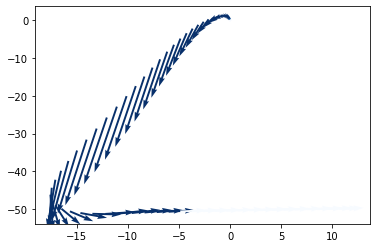

Character -> ['m']


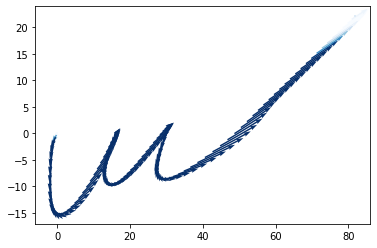

Character -> ['n']


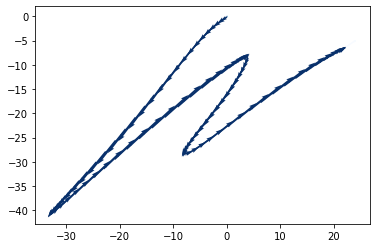

Character -> ['o']


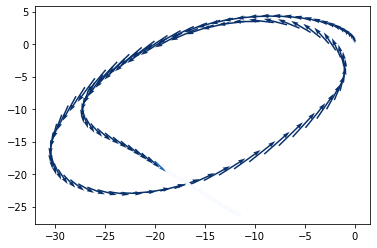

Character -> ['p']


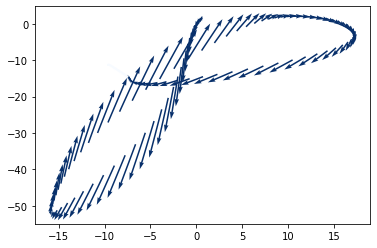

Character -> ['q']


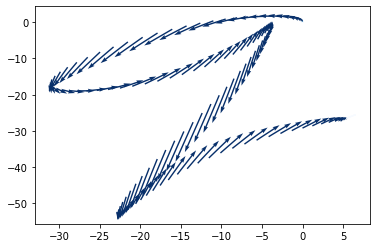

Character -> ['r']


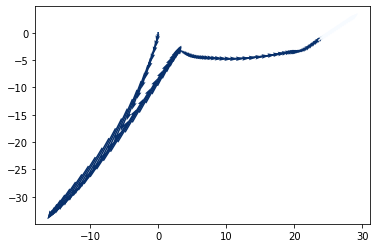

Character -> ['s']


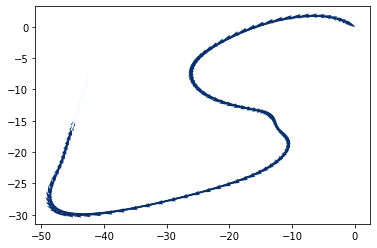

Character -> ['u']


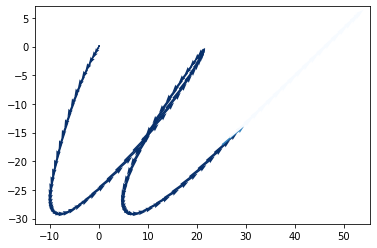

Character -> ['v']


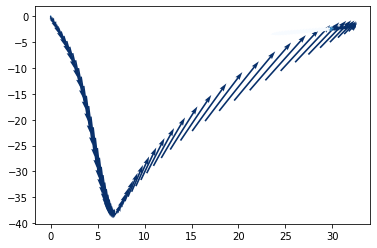

Character -> ['w']


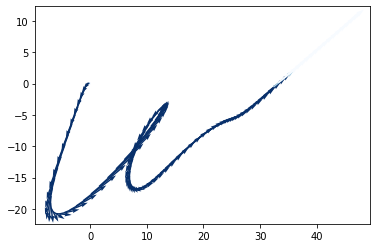

Character -> ['y']


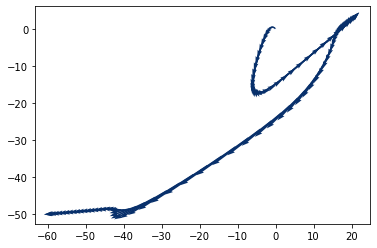

Character -> ['z']


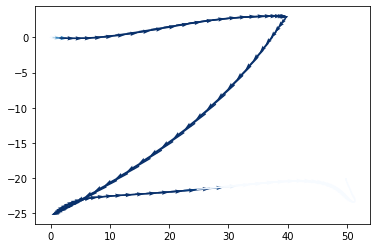

In [36]:
plot_character()

Define 1D CNN

In [61]:
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        # Convolution Layers
        self.conv1 = nn.Conv1d(3, 8, 3)
        self.conv2 = nn.Conv1d(8,24, 3)
        #Fully Connected Layers
        self.fc1 = nn.Linear(24 * 7 * 7, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        #Max Pool using RELU as activation
        x = function.max_pool1d(function.relu(self.conv1(x)), 2)
        x = function.max_pool1d(function.relu(self.conv2(x)), 2)
        x = x.view(-1, self.Flatten(x))
        x = function.relu(self.fc1(x))
        x = function.relu(self.fc2(x))
        return self.fc3(x)
        
    def Flatten(self, x):
        count = 1
        for i in x.size()[1:]:
            count *= i
        return count

SGD as Optimizer and Cross Entropy as Loss

In [76]:
model = CNN1D()
criterion = nn.CrossEntropyLoss()
sgd_optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
sgd_optimizer.zero_grad()

Load the dataset

In [66]:
def load_dataset():
  global mixout
  maximum_sample = max([len(sample[0]) for sample in mixout])
  # building the data dictionary
  dict1=[]
  for i,samp in enumerate(mixout):
    dict2=[]
    for j,channel in enumerate(samp):
        dict3=[]
        for k in range(maximum_sample):
            if k < len(channel):
                dict3.append(channel[k])
            else:
                dict3.append(0)
        dict2.append(dict3)        
    dict1.append(dict2)
  mixout = np.array(dict1)
  inputs = torch.from_numpy(mixout)
  labels = torch.from_numpy(constants_charlabels)
  # splitting the data for train and test 
  x_train, x_test = inputs[:len(mixout)-500, :], inputs[len(mixout)-500:, :]
  y_train, y_test = labels[:len(mixout)-500], labels[len(mixout)-500:]
  #print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
  return x_train, y_train, x_test, y_test

Train the CNN

In [67]:
def train_model(trainX, trainy):
  avg_loss = 0
  for i, (input,label) in enumerate(zip(trainX, trainy)):
    input = input.unsqueeze(0).float()
    label = label.unsqueeze(0).long()
    sgd_optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, label)
    loss.backward()
    sgd_optimizer.step()
    avg_loss += loss.item()
  return avg_loss/(len(trainy))

Test CNN

In [68]:
def test_model(testX, testY):
    avg_loss = 0.0
    for i, (input,label) in enumerate(zip(testX,testY)):
        input = input.unsqueeze(0).float()
        label = label.unsqueeze(0).long()
        sgd_optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, label)
        loss.backward()
        sgd_optimizer.step()
        predicted = output.softmax(dim=1)
        predicted = predicted.argmax(dim=1)
        avg_loss += loss.item()
    return avg_loss/(len(testY))

In [69]:
def summarize_results(scores):
  #print(scores)
  print('-' * 10)
  m, s = mean(scores), std(scores)
  print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
  print('-' * 10)
 
# run an experiment
def execute(repeats=10):
  # load data
  trainX, trainy, testX, testy = load_dataset()
  # repeat experiment
  scores = list()
  for r in range(repeats):
    score = train_model(trainX, trainy)
    print("epoch", r,"training loss -> %.8f" % score)
  print('-' * 10)
  for r in range(repeats):
    score = test_model(testX, testy)
    score = 100 - (score * 100.0)
    print('>#%d: %.3f' % (r+1, score))
    scores.append(score)
  # summarize results
  summarize_results(scores)

Run the experiment. It will first train the model and then test.

In [78]:
execute(50)

epoch 0 training loss -> 0.04638501
epoch 1 training loss -> 0.01756256
epoch 2 training loss -> 0.01311711
epoch 3 training loss -> 0.01062018
epoch 4 training loss -> 0.01015101
epoch 5 training loss -> 0.01001503
epoch 6 training loss -> 0.00931649
epoch 7 training loss -> 0.00852129
epoch 8 training loss -> 0.00831945
epoch 9 training loss -> 0.00801422
epoch 10 training loss -> 0.00726115
epoch 11 training loss -> 0.00740597
epoch 12 training loss -> 0.00695254
epoch 13 training loss -> 0.00743593
epoch 14 training loss -> 0.00762836
epoch 15 training loss -> 0.00747989
epoch 16 training loss -> 0.00774226
epoch 17 training loss -> 0.00780794
epoch 18 training loss -> 0.00745841
epoch 19 training loss -> 0.00649740
epoch 20 training loss -> 0.00618983
epoch 21 training loss -> 0.00587485
epoch 22 training loss -> 0.00552669
epoch 23 training loss -> 0.00308787
epoch 24 training loss -> 0.00239774
epoch 25 training loss -> 0.00222542
epoch 26 training loss -> 0.00195155
epoch 27 tr

Helper function to enable visualiztion of activation layer

In [59]:
def get_image(trainX, trainY):
  tensor_image = None
  for i, (input,label) in enumerate(zip(trainX, trainY)):
    input = input.unsqueeze(0).float()
    tensor_image = input
  return tensor_image

def VisualizeActivation():
  print("visualizing intermediate layer")
  trainX, trainY, _, _ = load_dataset()
  out = model.conv1(get_image(trainX, trainY))
  plt.figure()
  f, axarr = plt.subplots(1,1) 
  axarr.imshow(out[0].detach().numpy(), cmap='viridis', aspect='auto')

Display the activation layer

visualizing intermediate layer


<Figure size 432x288 with 0 Axes>

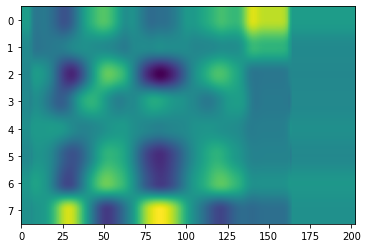

In [60]:
VisualizeActivation()